In [3]:
library(dplyr)
library(tidyr)
#install.packages('gender',lib=.libPaths()[3])
#install.packages("genderdata", repos = "http://packages.ropensci.org", type = "source",lib=.libPaths()[3])
library(gender)
library(stringr)
library(widyr)
library(readr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
block = read_csv("newdataCombined.csv")
block = block[block$Year >=2010 & block$Year <=2017,]
myvars <- c("AuthorIdsOrder", "AuthorNamesOrder", "Year", "PaperId")
data0 <- block[myvars]
data0$Year1 <-  data0$Year-35 #25-45
data0$Year2 <-  data0$Year-45 #35-55
data0$Year3 <-  data0$Year-55 #45-65
data0$authorCount <- str_count(data0$AuthorIdsOrder, '; ')+1
nrow(data0)

Parsed with column specification:
cols(
  Tag = col_character(),
  PaperId = col_double(),
  AuthorIdsOrder = col_character(),
  AuthorNamesOrder = col_character(),
  FoSNames = col_character(),
  Year = col_integer(),
  DocType = col_character(),
  Journal = col_character(),
  Publisher = col_character(),
  Doi = col_character(),
  Title = col_character(),
  EstimatedCitation = col_integer(),
  URLs = col_character(),
  IndexedAbstract = col_character()
)


[1] 2926

### We use "Year2" for birth year estimate, i.e. assuming authors are in the age range [35-55] when they publish. 

In [5]:
AuthorTable <- data0 %>% separate(AuthorNamesOrder, into = sprintf('%s.%s', rep('Author',100), rep(1:100)), sep = "; ") #max author has exceeded 90
AuthorTable <- AuthorTable %>% gather(authorOrder, name, into = sprintf('%s.%s', rep('Author',100), rep(1:100)))
AuthorList <- data.frame(lapply(AuthorTable, trimws), stringsAsFactors = FALSE)
nameTable <- AuthorList %>% separate(name, into = sprintf('%s.%s', rep('namePart',4), rep(1:4)), sep = " ")

Warning message:
“Too few values at 2926 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...”Warning message:
“Too many values at 111 locations: 667, 669, 843, 1038, 1120, 1322, 1577, 1744, 1946, 2020, 2181, 2220, 2280, 2301, 2390, 2841, 2843, 2858, 2859, 3145, ...”Warning message:
“Too few values at 13047 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...”

In [6]:
newvars <- c("PaperId","namePart.1", "namePart.2", "namePart.3", "namePart.4", "Year2", "authorOrder", "authorCount")
nameParts <- nameTable[newvars]
nameParts$namePart.1 <- gsub("\"", "", nameParts$namePart.1)
nameParts$namePart.2 <- gsub("\"", "", nameParts$namePart.2)
nameParts$namePart.3 <- gsub("\"", "", nameParts$namePart.3)
nameParts$namePart.4 <- gsub("\"", "", nameParts$namePart.4)
nameParts$min_years <- as.numeric(nameParts$Year2)-20
nameParts$max_years <- as.numeric(nameParts$Year2)+20
results <- gender_df(nameParts, name_col = "namePart.1", year_col = c("min_years", "max_years"), method = "ssa")
output <- nameParts %>% left_join(results, by = c("namePart.1" = "name", "min_years" = "year_min"))
results <- gender_df(nameParts, name_col = "namePart.2", year_col = c("min_years", "max_years"), method = "ssa")
output <- output %>% left_join(results, by = c("namePart.2" = "name", "min_years" = "year_min"))
results <- gender_df(nameParts, name_col = "namePart.3", year_col = c("min_years", "max_years"), method = "ssa")
output <- output %>% left_join(results, by = c("namePart.3" = "name", "min_years" = "year_min"))
output <- within(output, #if namepart3 is the last name, set it NA 
   temp2 <- ifelse(is.na(namePart.4),NA,proportion_female)
)
output <- within(output, #if namepart2 is the last name, set it NA 
   temp1 <- ifelse(is.na(namePart.3),NA,proportion_female.y)
)
output <- within(output, #if namepart1 is the last name, set it NA 
   temp0 <- ifelse(is.na(namePart.2),NA,proportion_female.x)
)
output <- within(output, # namepart2 merged with namepart3
   femaleProb0 <- ifelse(is.na(temp1),temp2,temp1)
)
output <- within(output, # namepart1 merged with namepart2
   femaleProb <- ifelse(is.na(temp0),temp1,temp0)
)
output <- within(output, # binarize the probabilities, with 1 representing female and 0 male
   genderLabel <- ifelse(femaleProb>0.5,1,0)
)
output %>% 
  group_by(genderLabel) %>%
  summarise(no_rows = length(genderLabel))

genderLabel,no_rows
0,6175
1,3162
NA,283263


### We break each author name into 4 parts, delimited by space in their full name. The detected gender probability of later name parts overwrite earlier ones. The final labels are given by binarizing the probabilities, with 1 representing female and 0 male.

In [7]:
newvars <- c("PaperId", "Year2", "authorOrder", "genderLabel", "authorCount")
merged <- output[newvars]
merged <- spread(merged, authorOrder, genderLabel)
merged$detectCount <- 100-rowSums(is.na(merged))
merged$femaleCount <- rowSums(merged[sapply(merged, is.numeric)], na.rm = TRUE) - merged$detectCount
merged$femaleProp <- merged$femaleCount/merged$detectCount
merged$femaleProp[is.infinite(merged$femaleProp) | is.nan(merged$femaleProp) ] <- NA
merged$authorCount <- as.numeric(merged$authorCount)
merged$unknownCount <- merged$authorCount-merged$detectCount
merged$lastColName <- paste("Author", merged$authorCount, sep=".") 
merged$last <- as.numeric(merged[cbind(1:nrow(merged),match(merged$lastColName, colnames(merged)))])
merged$PaperId <- as.numeric(merged$PaperId)
merged <- rename(merged, "1st" = "Author.1", "2nd" = "Author.2", "3rd" = "Author.3", "4th" = "Author.4", "5th" = "Author.5")
outputVars <- c("PaperId", "authorCount", "unknownCount", "femaleCount", "femaleProp", "1st", "2nd", "3rd", "4th", "5th", "last")
mergedSelect <-  merged[outputVars]
#write.csv(merged, file = "output.csv")

### Group gender detected results to papers. Besides paper level aggregate statistics, first 5 and the last authors are kepted for downstream analysis (OpenSci3.csv).

In [8]:
block0 <- block %>% left_join(merged, by = c("PaperId" = "PaperId"))
outputVars <- c("Tag", "PaperId", "AuthorIdsOrder", "AuthorNamesOrder", "authorCount", "unknownCount", "femaleCount", "femaleProp", "1st", "2nd", "3rd", "4th", "5th", "last",
                "FoSNames", "Year", "DocType", "Journal", "Publisher", "Doi", "Title", "EstimatedCitation", "IndexedAbstract")
data <- block0[outputVars]
write_csv(data, "OpenSci3.csv")
nrow(data)

[1] 2926

### Counting pie chart numbers for excel plotting (Pie.csv).

In [9]:
data$allmale <- as.numeric(data$"1st"==0) * as.numeric(data$last==0) * as.numeric(data$authorCount>1)
data$allfemale <- as.numeric(data$"1st"==1) * as.numeric(data$last==1) * as.numeric(data$authorCount>1)
data$mixed <- as.numeric(data$"1st"==1) + as.numeric(data$last==1)
data$mixed <- as.numeric(data$mixed==1)
data$allUnknown <- as.numeric(is.na(data$"1st")) * as.numeric(is.na(data$last)) * as.numeric(data$authorCount>1)
data$UnknownMale <- as.numeric(is.na(data$"1st")) * as.numeric(data$last==0)
data$UnknownFemale <- as.numeric(is.na(data$"1st")) * as.numeric(data$last==1)
data$maleUnknown <- as.numeric(is.na(data$last)) * as.numeric(data$"1st"==0)
data$femaleUnknown <- as.numeric(is.na(data$last)) * as.numeric(data$"1st"==1)
data$singleMale <- as.numeric(data$"1st"==0) * as.numeric(data$authorCount==1)
data$singleFemale <- as.numeric(data$"1st"==1) * as.numeric(data$authorCount==1)
data$singleUnknown <- as.numeric(is.na(data$"1st")) * as.numeric(data$authorCount==1)
outputVars <- c("Tag","allmale","allfemale","mixed","allUnknown","UnknownMale","UnknownFemale","maleUnknown","femaleUnknown","singleMale","singleFemale","singleUnknown")
dataOpen <- data[outputVars]
dataOpen <- dataOpen[dataOpen$Tag=="OpenScience",]
pieOpen <- dplyr::bind_rows(colSums(dataOpen[,-1], na.rm = TRUE))
dataRep <- data[outputVars]
dataRep <- dataRep[dataRep$Tag=="Reproducibility",]
pieRep <- dplyr::bind_rows(colSums(dataRep[,-1], na.rm = TRUE))
pie <- dplyr::bind_rows(list(OpenScience=pieOpen, Reproducibility=pieRep), .id = 'Tag')
pie$sum <- rowSums(pie[-1])
write_csv(pie, "Pie.csv")

In [10]:
pie

Tag,allmale,allfemale,mixed,allUnknown,UnknownMale,UnknownFemale,maleUnknown,femaleUnknown,singleMale,singleFemale,singleUnknown,sum
OpenScience,190,73,169,43,43,21,56,29,146,72,37,879
Reproducibility,419,80,326,345,200,66,165,104,194,76,72,2047


In [11]:
library(tibble)
single <- pie[c("singleMale","singleFemale","singleUnknown")]
single <- as.data.frame(t(single))
#calculate percentage
single$V1p <- single$V1 / sum(single$V1)
single$V2p <- single$V2 / sum(single$V2)
single <- rownames_to_column(single, "group") 
# Add label position for pie charts
single <- single %>%
  arrange(desc(group)) %>%
  mutate(lab.ypos1 = cumsum(V1p) - 0.5*V1p)
single <- single %>%
  arrange(desc(group)) %>%
  mutate(lab.ypos2 = cumsum(V2p) - 0.5*V2p)
single

group,V1,V2,V1p,V2p,lab.ypos1,lab.ypos2
singleUnknown,37,72,0.1450980,0.2105263,0.07254902,0.1052632
singleMale,146,194,0.5725490,0.5672515,0.43137255,0.4941520
singleFemale,72,76,0.2823529,0.2222222,0.85882353,0.8888889



Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor



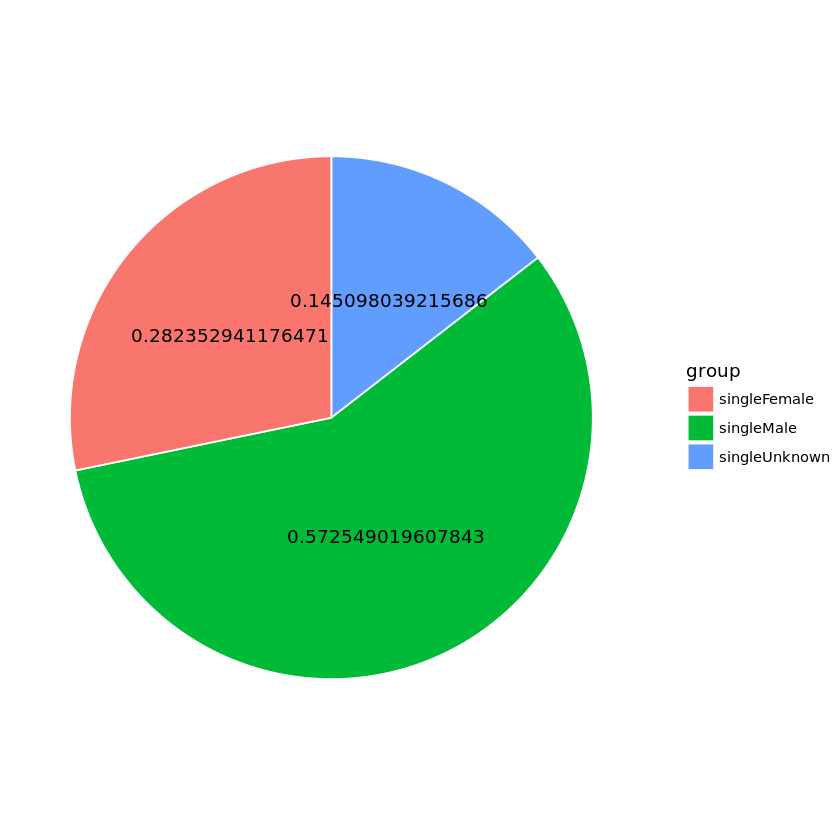

In [12]:
library(ggplot2)
library(scales)
bp<- ggplot(single, aes(x="", y=V1p, fill=group))+
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  geom_text(aes(y = lab.ypos1, label = V1p))+
  theme_void()
bp

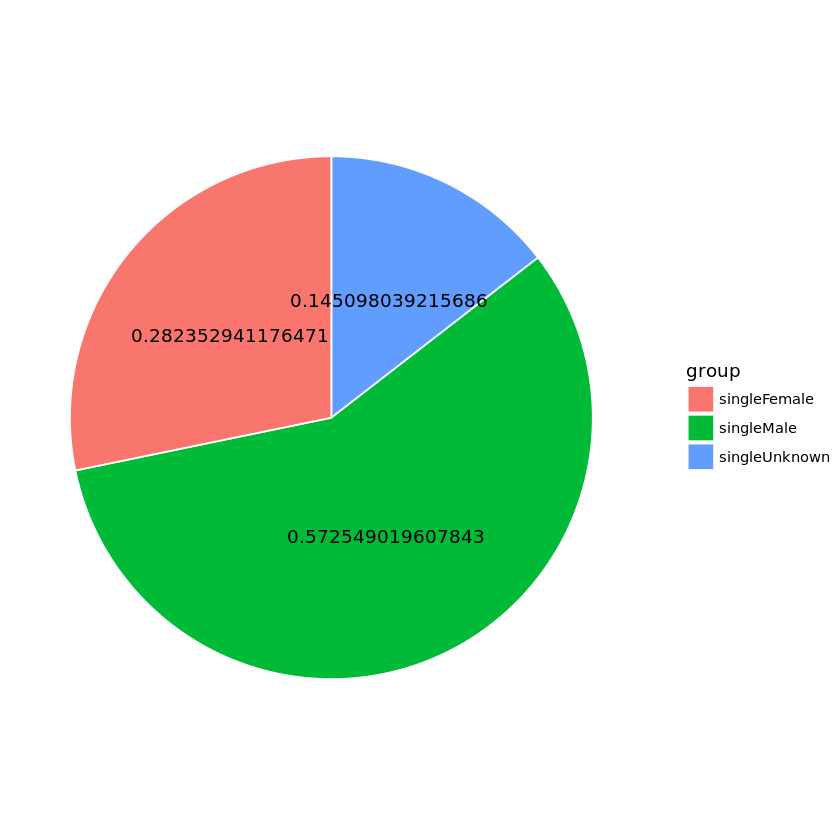

In [13]:
pie <- bp + coord_polar("y", start=0)
pie